## Library

Reference 1: https://keras.io/examples/nlp/text_classification_with_transformer/

Reference 2: http://peterbloem.nl/blog/transformers



In [ ]:
import numpy as np
import pandas as pd

In [ ]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 8.5 MB/s 


In [ ]:
import nltk, random
import numpy as np
from nltk.corpus import movie_reviews
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

## Transformer Block

In [ ]:
# soruce:(https://keras.io/examples/nlp/text_classification_with_transformer/)
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # layer norm

## Embedding and Position

- And in Transformer-based networks, we need to include positional information of the tokens in the embeddings.
- Again, we use the `TokenAndPositionEmbedding` provided in `keras`'s tutorial.

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Data

### Preprocessing Steps

In [ ]:
train = pd.read_csv('train.tsv',sep='\t')
valid = pd.read_csv('dev.tsv',sep='\t')
test = pd.read_csv('test.tsv',sep='\t')

In [ ]:
## Hyperparameters fot tokenizer
vocab_size = 20000
MAX_LEN = 256 
## texts vs. labels
texts = np.array(list(train["comment_text"]))
labels = np.array(list(train["label"]))


In [ ]:
## tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size,lower=False)
## fit tokenizer
tokenizer.fit_on_texts(texts)
## text to sequences
texts_to_int = tokenizer.texts_to_sequences(texts)
## pad sequences
texts_to_int_pad = keras.preprocessing.sequence.pad_sequences(texts_to_int,
                                                              maxlen=MAX_LEN,
                                                              truncating='post',
                                                              padding='post')

In [ ]:
## X and y for train and val
x_train = texts_to_int_pad
y_train = labels

In [ ]:
## X and y for train and val
x_train = texts_to_int_pad
y_train = labels

## Perform same vectorization on testing set
x_val_text = np.array(list(valid["comment_text"]))

x_val = keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(x_val_text),
    maxlen=MAX_LEN,
    truncating='post',
    padding='post'
)
    
y_val = np.array(list(valid["label"]))


## Define Classifier Architecture

- We then define the architecture of the network like before using `keras` Sequential or Functional API.
- The `TransformerBlock` and `TokenAndPositionEmbedding` function as like the other `keras.layers`.

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

## Using Sequential API
model = keras.Sequential()
model.add(layers.Input(shape=(MAX_LEN, )))
model.add(TokenAndPositionEmbedding(MAX_LEN, vocab_size, embed_dim))
model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(ff_dim, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  (None, 256, 32)          648192    
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_1 (Transf  (None, 256, 32)          10656     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 32)               

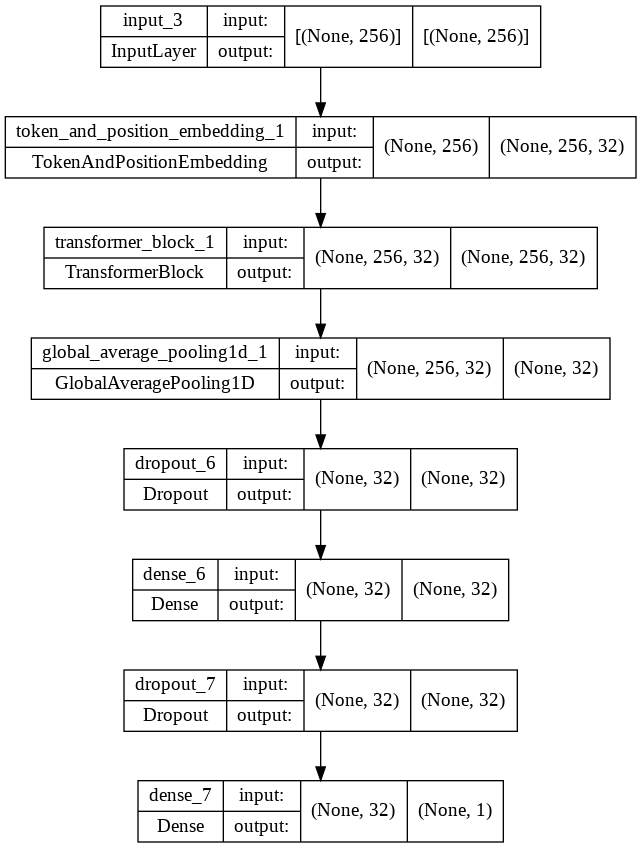

In [ ]:
#First time in actually setting the model
keras.utils.plot_model(model, show_shapes=True)

## Training

In [ ]:
import tqdm
import tensorflow_addons as tfa
# initialize tqdm callback with default parameters
tqdm_callback = tfa.callbacks.TQDMProgressBar()

In [ ]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(x_train,y_train,
                    batch_size=128, epochs=10,
                    validation_data=(x_val, y_val),
                    callbacks = [tqdm_callback],
                    verbose=0)

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/501           ETA: ?s - 

Epoch 2/10


0/501           ETA: ?s - 

Epoch 3/10


0/501           ETA: ?s - 

Epoch 4/10


0/501           ETA: ?s - 

Epoch 5/10


0/501           ETA: ?s - 

Epoch 6/10


0/501           ETA: ?s - 

Epoch 7/10


0/501           ETA: ?s - 

Epoch 8/10


0/501           ETA: ?s - 

Epoch 9/10


0/501           ETA: ?s - 

Epoch 10/10


0/501           ETA: ?s - 

## Ploting Training Results

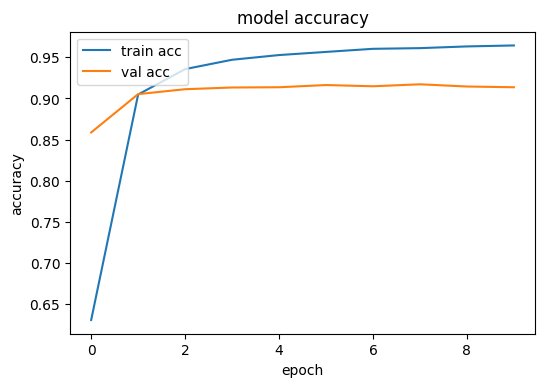

In [ ]:
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train acc', 'val acc'], loc='upper left')
plt.show()

In [ ]:
model.save('/content')

INFO:tensorflow:Assets written to: /content/assets


INFO:tensorflow:Assets written to: /content/assets


# Make prediction

In [ ]:
## Perform same vectorization on testing set
x_test_text = np.array(list(test["comment_text"]))

x_test = keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(x_test_text),
    maxlen=MAX_LEN,
    truncating='post',
    padding='post'
)
    
y_test = np.array(list(test["label"]))


In [ ]:
preds = model.predict(x_test)

In [ ]:
#(1-p,p) pair for negative/positive values
preds_final = np.array([[float(1 - x), float(x)] for x in preds])

In [ ]:
preds_final[:5]

array([[4.58955765e-05, 9.99954104e-01],
       [9.94912088e-01, 5.08792140e-03],
       [9.99965787e-01, 3.42335697e-05],
       [4.00364399e-04, 9.99599636e-01],
       [5.96188188e-01, 4.03811842e-01]])

In [ ]:
y_test[:5]

array([1, 0, 1, 1, 0])

In [ ]:
#Need conversion for negative
final_preds_converted = []
for i,x in enumerate(preds_final):
  if x[0]>x[1]:
    final_preds_converted.append(0)
  else:
    final_preds_converted.append(1)

In [ ]:
final_preds_converted[:5]

[1, 0, 0, 1, 0]

In [ ]:
import sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Prediction Accuracy is",sklearn.metrics.accuracy_score(y_test, final_preds_converted))
print("\n\n")
print(classification_report(y_test, final_preds_converted))
print("\n\n")
print(confusion_matrix(y_test, final_preds_converted))

Prediction Accuracy is 0.7809633027522935



              precision    recall  f1-score   support

           0       0.77      0.79      0.78       428
           1       0.79      0.78      0.78       444

    accuracy                           0.78       872
   macro avg       0.78      0.78      0.78       872
weighted avg       0.78      0.78      0.78       872




[[336  92]
 [ 99 345]]
